# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project. Bekijk project-deel-1 om het data cleaning proces te zien.

De voorspellingen van dit project hebben als doel om het aantal dagen tussen het boeken en het vertrek van een reis te voorspellen aan de hand van enkel features en modellen.

In [678]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_classification

# 1 - Features behandelen

## 1.1 - Inlezen features

Onderstaande code leest het *featuresDataFrame.csv* bestand in en zet deze om naar een dataframe. In deel 1 van het project is er nog een aanpassing gebeurd, de kolom *Geboortedatum* werd alsnog meegenomen om hierna verdere berekeningen te kunnen doen (berekenen van de leeftijd). De kolom *Aantal dagen tot vertrek* en *Aantal dagen op reis* waren achteraf gezien niet goed berekend waardoor deze opnieuw zijn berekend en omgezet. Dit zorgde voor een afname van negatieve tijden die dan verwijderd zijn, dit zorgde voor een afname van heel wat lijnen waardoor er nu nog 2401 rijen over zijn.

In [679]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

### 1.2 - Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een timedelta was (*Aantal dagen tot vertrek* en de %Aantal dagen op reis* kolom) moet worden omgezet zodat er terug met kan worden gewerkt.

De kolom *Land* bevat de afkorting van het land waar de klant afkomstig van is. Om deze data in een model te kunnen gebruiken als feature worden deze gegevens omgezet in een cijfer. De onderstaande lijst toont de eerste 5 landen met hun corresponderende cijfer.

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Groot Brittannië

Elk reistype is ook eveneens omgezet in een cijfer. De onderstaande lijst toont de reis types met hun corresponderende cijfer.

- 1 Ruitervakantie
- 2 Ponykamp
- 3 Ruitervakantie& Vliegreis
- 4 Trektocht
- 5 Ruitervakantie Eigen Vervoer
- 6 Huifkar tocht
- 7 Safari
- 8 Jeugdkamp
- 9 Weekendje weg

In [680]:
def convert_timedelta(df_col):
    for index, row in enumerate(df_col):
        days, rest = row.split(" days")
        df_col.iloc[index] = days
    return df_col

def convert_land(df_land):
    for index, row in enumerate(df_land):
        if row == 'be':
            df_land.iloc[index] = 1
        elif row == 'nl':
            df_land.iloc[index] = 2
        elif row == 'fr':
            df_land.iloc[index] = 3
        elif row == 'de':
            df_land.iloc[index] = 4
        elif row == 'gb':
            df_land.iloc[index] = 5  
        elif row == 'lux':
            df_land.iloc[index] = 6
        elif row == 'sco':
            df_land.iloc[index] = 7
        elif row == 'pt':
            df_land.iloc[index] = 8
        elif row == 'sco':
            df_land.iloc[index] = 9
        elif row == 'sr':
            df_land.iloc[index] = 10
        elif row == 'cn':
            df_land.iloc[index] = 11
        elif row == 'aut':
            df_land.iloc[index] = 12
        elif row == 'ca':
            df_land.iloc[index] = 13   
        elif row == 'it':
            df_land.iloc[index] = 14
        elif row == 'es':
            df_land.iloc[index] = 15
        elif row == 'cl':
            df_land.iloc[index] = 16

def convert_reis_type(df_reistype):
    for index, row in enumerate(df_reistype):
        if row == 'Ruitervakantie':
            df_reistype.iloc[index] = 1
        elif row == 'Ponykamp':
            df_reistype.iloc[index] = 2
        elif row == 'Ruitervakantie& Vliegreis':
            df_reistype.iloc[index] = 3
        elif row == 'Trektocht':
            df_reistype.iloc[index] = 4
        elif row == 'Ruitervakantie Eigen Vervoer':
            df_reistype.iloc[index] = 5  
        elif row == 'Huifkar tocht':
            df_reistype.iloc[index] = 6
        elif row == 'Safari':
            df_reistype.iloc[index] = 7
        elif row == 'Jeugdkamp':
            df_reistype.iloc[index] = 8
        elif row == 'Weekendje weg':
            df_reistype.iloc[index] = 9

features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
    
features['Aantal dagen tot vertrek'] == convert_timedelta(features['Aantal dagen tot vertrek'])
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype(int)

features['Aantal dagen op reis'] == convert_timedelta(features['Aantal dagen op reis'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype(int)
            
features['Land'] == convert_land(features['Land'])
features['Land'] = features['Land'].astype(int)

features['Reistype'] == convert_reis_type(features['Reistype'])
features['Reistype'] = features['Reistype'].astype(int)      

features['Totaalprijs'] = features['Totaalprijs'].replace(',', '.', regex=True)
features['Totaalprijs'] = features['Totaalprijs'].astype(float)

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## 1.3 - Berekenen leeftijd

De onderstaande code zet de geboortedatum om naar de huidige leeftijd, de lege waarden worden opgevuld met een gemiddelde leeftijd van 42 jaar omdat ik er vanuit ga dat de gemiddelde persoon in de data ongeveer 42 jaar oud is. 

In [681]:
features['Geboortedatum'] = pd.to_datetime(features['Geboortedatum'], errors = 'coerce')
features['Leeftijd'] = datetime.datetime.now().year - pd.DatetimeIndex(features['Geboortedatum']).year
features['Leeftijd'] = features['Leeftijd'].fillna(42)
features['Leeftijd'] = features['Leeftijd'].astype(int);

## 1.4 -  Omzetten bestemmingen
    
De bestemmingen data is door het bedrijf manueel ingevoerd. Om de bestemmingen te kunnen koppelen aan een land heb  ik gekozen om elk land om te zetten naar een cijfer. Deze onderstaande lijst toont de eerste 10 landen met hun cijfer en de laatste 5 landen. Heel wat reizen bevatten geen directe aanwijzing naar het land maar hebben vaak een bekende stad of streek in de omschrijving, door deze te gaan groeperen konden alle bestemmingen worden omgezet naar hun corresponderende cijfer. Een 20 tal bestemmingen bevatte geen duidelijke aanwijzing naar een land of streek, hiervoor heb ik besloten om deze te verwijderen.

- 1 België
- 2 Nederland
- 3 Frankrijk
- 4 Duitsland
- 5 Portugal
- 6 Ijsland
- 7 Italië
- 8 Ierland
- 9 De Verenigde Staten
- 10 Jordanië

**De laatste 5**
- 52 Rusland
- 53 Columbia
- 54 Australië
- 55 Oostenrijk
- 56 Oman

In [682]:
nederland = ['friese', 'nederland', 'netherlands', 'vlieland', 'brabant', 'twente', 'drenthe', 'limburg', 'brabantse', 'nederlands', 'duinen', 'salland', 'zeeland', 'ijslanders']
belgie = ['ardennen', 'belgium', 'ardenne', 'belgië', 'belgie', 'arrdennen', 'eifel', 'ardennen', 'ardenen']
frankrijk = ['frankrijk', 'mont saint michel', 'morvan', 'dartmoor', 'couleurs corse', 'vogezen', 'margeride', 'haute valee', 'jura', 'normandië', 'médoc', 'montmorillonnais', 'france', 'loire', 'wijnroute', 'wijngaarden', 'elzas', 'pyreneeën', 'dordogne', 'pyreneeen', 'corsica', 'aude', 'frans', 'armagnac', 'frankrijjk', 'frankijk']
duitsland = ['germany', 'duitsland', 'thuringen', 'beieren', 'duitsand', 'duitse', 'thüringen']
spanje = ['spain', 'spanje', 'sulayr', 'alpujarra', 'middellandse', 'demanda', 'monfrague', 'andalusisch', 'costa brava', 'sierra nevada', 'catalonië','catalonie', 'gredos', 'andalusië', 'ronda', 'andalusie', 'conquistadores']
italie = ['italy', 'italie', 'sicilië', 'madonie', 'italië', 'sardinië', 'sardinie', 'toscane', 'molise', 'alta maremma', 'molise abruzzen']
portugal = ['portugal', 'lusitano', 'faro', 'algarve', 'lissabon', 'portugese', 'azoren']
usa = ['verenigde staten', 'montana', 'usa', 'united states', 'wyoming', 'ranch', 'colorado']
kroatie = ['kroatie', 'croatia', 'kroatië', 'istrië', 'plitvice', 'rode-meer', 'dalmatie', 'istrie']
allerlei = ['Klassieke dressuur van topkwaliteit en stedenschoon', 'Avontuurlijke trektocht door een sprookjesachtig gebied', 'Trektocht in het spoor van de tuimelaar-dolfijn ',
       'Driedaagse trektocht in het land van d\x19Oc en d\x19Oil', 'Trektocht over de bergen naar de zee', 'Trektocht in het spoor van de tuimelaar-dolfijn','Paardrijden langs de route van de bandieten', 'De \x18Great Trek\x19: werkelijk avontuurlijke trektocht',
       'Beach and Bush Rides', 'Dressuurweek','Een week paardrijden met jongvolwassenen','National Park: paardrijden voor pure ontspanning',
       'Driedaagse tocht door de Vienne-vallei','Trektocht naar de gouden stranden','Trektocht tussen zee en woestijnbergen', 'Programma Full','Smokkelaarstocht', 'Trektocht over de bergen naar zee','Beach and Meadows trektocht','De "legendes van de Wolf"-trektocht','Standplaatsvakantie Stertochten']

def convert_bestemmingen():
    for index, row in enumerate(features['Bestemming']):
        if any(ext in (str(row).lower()) for ext in belgie):
            features['Bestemming'].iloc[index] = 1
        elif any(ext in (str(row).lower()) for ext in nederland):
            features['Bestemming'].iloc[index] = 2
        elif any(ext in (str(row).lower()) for ext in frankrijk):
            features['Bestemming'].iloc[index] = 3
        elif any(ext in (str(row).lower()) for ext in duitsland):
            features['Bestemming'].iloc[index] = 4
        elif any(ext in (str(row).lower()) for ext in portugal):
            features['Bestemming'].iloc[index] = 5
        elif any(ext in (str(row).lower()) for ext in ['ijsland', 'iceland', 'geysir', 'golden circle']):
            features['Bestemming'].iloc[index] = 6
        elif any(ext in (str(row).lower()) for ext in italie):
            features['Bestemming'].iloc[index] = 7
        elif any(ext in (str(row).lower()) for ext in ['ierland', 'ireland', 'galway', 'ierse', 'donegal']):
            features['Bestemming'].iloc[index] = 8
        elif any(ext in (str(row).lower()) for ext in usa):
            features['Bestemming'].iloc[index] = 9
        elif any(ext in (str(row).lower()) for ext in ['jordanie', 'jordan', 'wadi rum']):
            features['Bestemming'].iloc[index] = 10
        elif any(ext in (str(row).lower()) for ext in spanje):
            features['Bestemming'].iloc[index] = 11
        elif any(ext in (str(row).lower()) for ext in ['botswana']):
            features['Bestemming'].iloc[index] = 12
        elif any(ext in (str(row).lower()) for ext in ['canada', 'yukon', 'alberta', 'saskatchewan']):
            features['Bestemming'].iloc[index] = 13
        elif any(ext in (str(row).lower()) for ext in ['roemenie', 'roemenië', 'transsylvanie', 'transsylvanië']):
            features['Bestemming'].iloc[index] = 14
        elif any(ext in (str(row).lower()) for ext in ['chili', 'chile']):
            features['Bestemming'].iloc[index] = 15
        elif any(ext in (str(row).lower()) for ext in ['marokko', 'marokkaanse', 'berbers']):
            features['Bestemming'].iloc[index] = 16
        elif any(ext in (str(row).lower()) for ext in ['griekenland', 'petra', 'kreta', 'kefalonia']):
            features['Bestemming'].iloc[index] = 17
        elif any(ext in (str(row).lower()) for ext in ['zuid afrika', 'south africa', 'afrika']):
            features['Bestemming'].iloc[index] = 18
        elif any(ext in (str(row).lower()) for ext in ['bulgarije', 'bulgaria', 'balkan']):
            features['Bestemming'].iloc[index] = 19
        elif any(ext in (str(row).lower()) for ext in ['hongarije', 'poesta', 'homgarije']):
            features['Bestemming'].iloc[index] = 20
        elif any(ext in (str(row).lower()) for ext in ['tsjechie', 'tsjechië', 'zuid-bohemen', 'karpaten']):
            features['Bestemming'].iloc[index] = 21   
        elif any(ext in (str(row).lower()) for ext in ['cappadocië', 'turkije', 'turklije', 'thracians']):
            features['Bestemming'].iloc[index] = 22
        elif any(ext in (str(row).lower()) for ext in ['polen', 'poolse', 'poland']):
            features['Bestemming'].iloc[index] = 23
        elif any(ext in (str(row).lower()) for ext in ['namibie', 'namibië']):
            features['Bestemming'].iloc[index] = 24
        elif any(ext in (str(row).lower()) for ext in ['kirgizie', 'kirgizië']):
            features['Bestemming'].iloc[index] = 25
        elif any(ext in (str(row).lower()) for ext in ['montenegro']):
            features['Bestemming'].iloc[index] = 26
        elif any(ext in (str(row).lower()) for ext in ['zweden']):
            features['Bestemming'].iloc[index] = 27
        elif any(ext in (str(row).lower()) for ext in ['albanie', 'albanië', 'katharen']):
            features['Bestemming'].iloc[index] = 28
        elif any(ext in (str(row).lower()) for ext in ['mongolië', 'mongolie', 'mongoolse']):
            features['Bestemming'].iloc[index] = 29
        elif any(ext in (str(row).lower()) for ext in kroatie):
            features['Bestemming'].iloc[index] = 30
        elif any(ext in (str(row).lower()) for ext in ['costa rica']):
            features['Bestemming'].iloc[index] = 31
        elif any(ext in (str(row).lower()) for ext in ['slowakije']):
            features['Bestemming'].iloc[index] = 32
        elif any(ext in (str(row).lower()) for ext in ['brazilie', 'santa catarina gaucho']):
            features['Bestemming'].iloc[index] = 33
        elif any(ext in (str(row).lower()) for ext in ['denemarken', 'denmark', 'deense']):
            features['Bestemming'].iloc[index] = 34
        elif any(ext in (str(row).lower()) for ext in ['noorwegen', 'norway', 'ramsjo-special', 'northern', 'scandinavische']):
            features['Bestemming'].iloc[index] = 35
        elif any(ext in (str(row).lower()) for ext in ['azerbidjan']):
            features['Bestemming'].iloc[index] = 36
        elif any(ext in (str(row).lower()) for ext in ['georgie', 'georgië', 'georgia']):
            features['Bestemming'].iloc[index] = 37
        elif any(ext in (str(row).lower()) for ext in ['zwitserland']):
            features['Bestemming'].iloc[index] = 38
        elif any(ext in (str(row).lower()) for ext in ['groot-brittanie', 'wales', 'britain', 'engeland']):
            features['Bestemming'].iloc[index] = 39
        elif any(ext in (str(row).lower()) for ext in ['argentinie', 'argentinië', 'noord-argentinië']):
            features['Bestemming'].iloc[index] = 40
        elif any(ext in (str(row).lower()) for ext in ['cuba']):
            features['Bestemming'].iloc[index] = 41
        elif any(ext in (str(row).lower()) for ext in ['lapland', 'finland']):
            features['Bestemming'].iloc[index] = 42
        elif any(ext in (str(row).lower()) for ext in ['mexico']):
            features['Bestemming'].iloc[index] = 43
        elif any(ext in (str(row).lower()) for ext in ['china']):
            features['Bestemming'].iloc[index] = 44
        elif any(ext in (str(row).lower()) for ext in ['kenia']):
            features['Bestemming'].iloc[index] = 45
        elif any(ext in (str(row).lower()) for ext in ['iran']):
            features['Bestemming'].iloc[index] = 46
        elif any(ext in (str(row).lower()) for ext in ['servië', 'servie', 'sumadija']):
            features['Bestemming'].iloc[index] = 47
        elif any(ext in (str(row).lower()) for ext in ['schotland']):
            features['Bestemming'].iloc[index] = 48
        elif any(ext in (str(row).lower()) for ext in ['egypte', 'sahara']):
            features['Bestemming'].iloc[index] = 49
        elif any(ext in (str(row).lower()) for ext in ['andorra']):
            features['Bestemming'].iloc[index] = 50
        elif any(ext in (str(row).lower()) for ext in ['uruguay']):
            features['Bestemming'].iloc[index] = 51
        elif any(ext in (str(row).lower()) for ext in ['rusland']):
            features['Bestemming'].iloc[index] = 52
        elif any(ext in (str(row).lower()) for ext in ['columbia', 'colombiaans']):
            features['Bestemming'].iloc[index] = 53
        elif any(ext in (str(row).lower()) for ext in ['australie']):
            features['Bestemming'].iloc[index] = 54
        elif any(ext in (str(row).lower()) for ext in ['oostenrijk']):
            features['Bestemming'].iloc[index] = 55
        elif any(ext in (str(row).lower()) for ext in ['oman']):
            features['Bestemming'].iloc[index] = 56
        elif any(ext in str(row) for ext in allerlei):
            rows = features['Bestemming'].index[[index]]
            features['Bestemming'] = features['Bestemming'].drop(rows)
    
    return features['Bestemming']

features['Bestemming'] == convert_bestemmingen()
features = features[features['Bestemming'].notna()]
features['Bestemming'] = features['Bestemming'].astype(int)

## 1.5 -  Aanpassen categorieën *Aantal dagen tot vertrek*

De kolom *Aantal dagen tot vertrek* bevat steeds een cijfer dat aangeeft in welke categorie de reis valt tussen het aantal dagen na het bestellen van een reis en het effectief vertrekken op reis. De kolom *delta periode vertrek* bevat de originele datums om later met linaire regressie de duur van een reis te voorspellen.

De aantal dagen worden omgezet in en cijfer dat een periode weergeeft, onderstaande lijst toont de betekenis van elk cijfer.

- 1: 1 tot 14 dagen
- 2: 15 tot 30 dagen
- 3: 31 tot 60 dagen
- 4: 61 tot 100 dagen
- 5: 101 dagen en meer

Mijn keuze werd mede bepaald door deze onderstaande grafiek dat weergeeft hoeveel klanten er een wachtperiode hebben tussen het boeken van een reis en het vertrekken op reis. Deze grafiek liet mij zin dat het grootste deel van de klanten minder dan 100-120 dagen na het boeken al vertrekt op reis, aan de hand hiervan heb ik dan een target gemaakt dat 5 types bevat, elk type wordt ingedeeld volgens de waarde waartussen het aantal dagen valt. Zo wordt een reis dat tussen 1 en 14 dagen valt het cijfer 1 gegeven, voor 15 tot 30 dagen het cijfer 2 en zo verder.

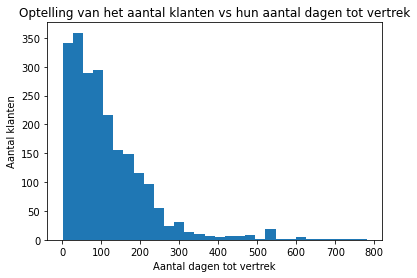

In [683]:
df = features['Aantal dagen tot vertrek']
plt.hist(df, bins = 30)
plt.xlabel("Aantal dagen tot vertrek")
plt.ylabel("Aantal klanten")
plt.title("Optelling van het aantal klanten vs hun aantal dagen tot vertrek");

In [684]:
features['delta periode vertrek'] = features.loc[:, 'Aantal dagen tot vertrek'] 

for index, row in enumerate(features['Aantal dagen tot vertrek']):
    if (row >= 1) & (row <= 14):
        features['Aantal dagen tot vertrek'].iloc[index] = 1
    elif (row >= 15) & (row <= 30):
        features['Aantal dagen tot vertrek'].iloc[index] = 2
    elif (row >= 31) & (row <= 60):
        features['Aantal dagen tot vertrek'].iloc[index] = 3
    elif (row >= 61) & (row <= 100):
        features['Aantal dagen tot vertrek'].iloc[index] = 4
    elif (row >= 101):
        features['Aantal dagen tot vertrek'].iloc[index] = 5

De onderstaande lijst toont voor elke kolom het datatype. Alle kolommen zijn omgezet naar int, float of datetime. De integer en float waarden kunnen worden gebruikt als feature.

In [685]:
features.dtypes

Status                               int64
Dossier jaar                         int64
Dossier nr.                          int64
Klantnummer                         object
Datum creatie               datetime64[ns]
Datum vertrek               datetime64[ns]
Datum terug                 datetime64[ns]
Totaalprijs                        float64
Betalingen dossier                 float64
Openstaand dossier                 float64
Land                                 int64
Bestemming                           int64
Reistype                             int64
Aantal reizigers                     int64
Aantal dagen tot vertrek             int64
Aantal dagen op reis                 int64
Geboortedatum               datetime64[ns]
Leeftijd                             int64
delta periode vertrek                int64
dtype: object

## 1.6 - Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en datums zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd. De zaken die daarnet werden berekend moeten ook weggelaten worden uit het dataframe om te voorkomen dat het model te sterk trekt naar de gecoreleerde data.

In [686]:
features.sample(10)

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis,Geboortedatum,Leeftijd,delta periode vertrek
1373,1,2017,3069,f3e41b0b2d4b53b3,2017-05-23,2017-07-22,2017-07-29,749.00,749.00,0.0,2,23,1,1,3,7,NaT,42,60
597,1,2013,1506,e3864cf03b5beef0,2014-06-28,2014-08-08,2014-10-08,975.00,975.00,0.0,2,2,1,3,3,61,NaT,42,41
1487,1,2017,3304,e449d982e9bc0333,2017-11-13,2017-11-18,2017-11-25,1174.61,1174.61,0.0,2,11,1,1,1,7,NaT,42,5
507,1,2013,1258,ee04ef5c97b382a8,2014-05-02,2014-07-19,2014-07-26,1820.00,1820.00,0.0,2,3,1,2,4,7,NaT,42,78
685,1,2014,1694,61c31ca435dbeb02,2015-01-22,2015-06-13,2015-06-20,836.91,836.91,0.0,2,7,1,1,5,7,NaT,42,142
2017,1,2019,20190404,11b5de99aa518265,2019-07-28,2019-08-17,2019-08-24,1185.00,1185.00,0.0,2,11,1,1,2,7,1988-09-03,33,20
256,1,2012,689,d0c4d8eb6f2f3dac,2012-12-13,2012-12-30,2013-06-01,500.00,500.00,0.0,2,16,1,1,2,153,NaT,42,17
1125,1,2016,2579,ed34923408b403a9,2016-07-31,2016-08-15,2016-08-17,182.00,182.00,0.0,2,2,1,1,2,2,NaT,42,15
1014,1,2016,2350,0be58378f0d29024,2016-01-04,2016-04-17,2016-04-24,1732.50,1732.50,0.0,2,11,1,1,5,7,1937-12-22,84,104
392,1,2013,1055,adbd8175e11182fc,2013-06-30,2013-07-09,2013-09-14,1216.19,1216.19,0.0,2,20,1,1,1,67,1963-03-13,58,9


# 2 - Evalueren en selecteren van features

Enkele interessante features die in de dataset te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Land**: Het thuisland van de reiziger (omgezet is een cijfer).
 - **Bestemming**: Het land waar de reiziger naartoe geweest is (omgezet in een cijfer).
 - **Reistype**: Het type reis (omgezet in een cijfer).
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen tussen het aanmaken van een boeking en de vertrek datum (omgezet in een cijfer, opgedeeld in een categorie).
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.
 - **Leeftijd**: Leeftijd van de klant.
 - **Delta periode vertrek**: Het berekende aantal dagen tussen het aanmaken van een boeking en de vertrek datum (de effectieve waarde, feature: *Aantal dagen tot vertrek* is hetzelfde maar als categorie).
 

## 2.1 - Correlatie tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de score bij 1 ligt hoe dichter de features gecorreleerd zijn met elkaar. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

In de matrix zien we dat er enkele features een goede correlatie hebben met elkaar (hoger dan 0.4).
Zo zijn het *aantal reizigers*, *aantal dagen tot vertrek*, de *totaal prijs*, het *dossier nummer* en *dossier jaar* features die een verband hebben met elkaar. Omdat er enkele features (*Dossies nummer* en *Dossier jaar* & *Totaalprijs* en *Betalingen Dossier*) een hoge correlatie hebben kan dit zorgen voor overfitting, hierdoor is het best om één van de twee waarden niet op te nemen als feature in het model.
Bij het splitten van de train en test data zullen de kolommen *Dossier nr.* en *Betalingen Dossier* weggelaten worden.

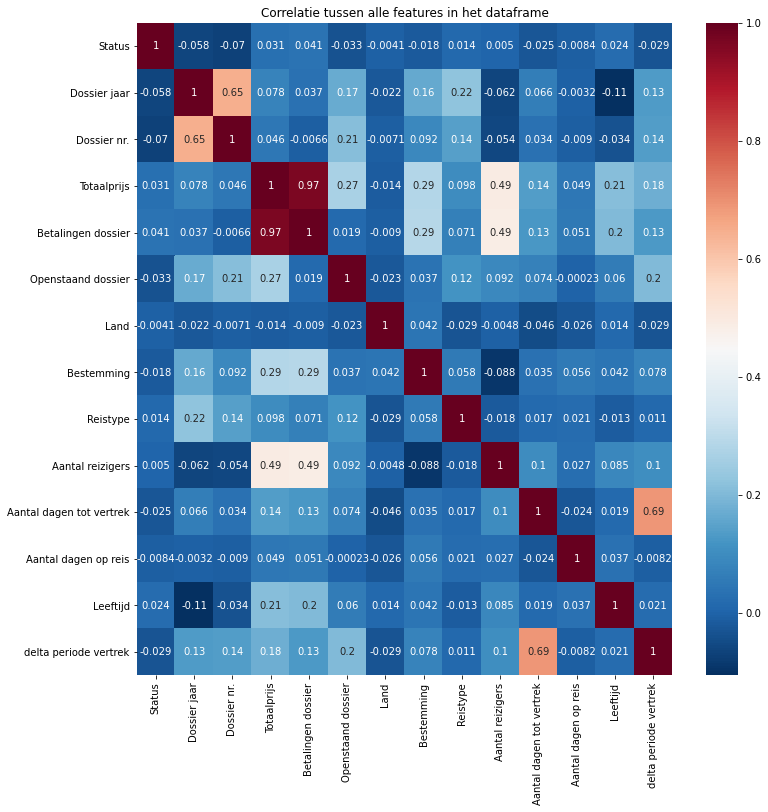

In [687]:
plt.figure(figsize=(12, 12))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

## 2.2 - Opsplitsen van train en test data

Onderstaande code splitst de data op in train en test data. In dit geval wordt de data opgesplitst volgens de standaard 75% train data en 25% test data. De niet numerieke kolommen worden uit de dataset weggelaten en de target wordt ingesteld in de *y* array. Om de data te schalen maak ik gebruik van de StandardScaler. Het idee hierachter is dat het de gegevens zodanig zal transformeren dat de distributie een gemiddelde waarde en een standaardafwijking krijgt zodat elke feature de juiste inbreng heeft.

Bij Multivariate data gebeurt dit transformeren feature-wise (dus onafhankelijk voor elke kolom van de data).
Gezien de verdeling van de gegevens, wordt bij elke waarde in de gegevensset de gemiddelde waarde afgetrokken en vervolgens gedeeld door de standaarddeviatie van de hele gegevensset (of kenmerk in het multivariate geval).

De volgende kolommen worden verwijderd uit het features dataframe:
 - **Klantnummer** Een klantnummer is geen numerieke waarde dus dit kan niet meegeven worden aan modellen.
 - **Geboortedatum** De kolom met geboortedatums is geen numerieke waarde en de leeftijd is hieruit berekend dat wel als feature kan dienen.
 - **Dossier nr.** De kolom met de dossier nummers had een hoge correlatie met het dossier jaar waardoor het interessant is om deze niet mee op te nemen in de features lijst, dit kan het model ten goede komen omdat er overfitting kan ontstaan met hoog gecorreleerde features onderling.
 - **Betalingen dossier** Het bedrag dat al reeds betaald was is ook hoog gecorreleerd met het totaal bedrag waardoor deze kolom ook kan worden weggelaten uit de features.
 - **Datums** De kolommen *Datum creatie*, *Datum vertrek* en *Datum terug* zijn datums die al gebruikt zijn om zaken te berekenen (Aantal dagen op reis en Aantal dagen tot vertrek).

De *delta periode vertrek* is enkel nuttig bij linaire regresie waardoor deze feature ook niet mag gebruikt worden bij de classifier modellen. Deze feature is ook gecorreleerd met de target waardoor deze niet mag worden gebruikt.

In [688]:
features

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis,Geboortedatum,Leeftijd,delta periode vertrek
0,1,2011,10,88f48bf74d1558fe,2011-02-05,2011-05-15,2011-05-21,2549.00,2549.00,0.00,1,5,1,2,4,6,NaT,42,99
1,1,2011,11,14fa899cbefcd9ec,2011-02-05,2011-07-16,2011-07-22,540.00,540.00,0.00,2,2,1,2,5,6,NaT,42,161
2,1,2011,13,5c09ae179c7894ca,2011-03-05,2011-07-30,2011-08-13,2510.96,2510.96,0.00,1,3,1,2,5,14,1972-09-26,49,147
3,1,2011,14,9074500e4eac155e,2011-05-05,2011-07-25,2011-07-27,326.95,326.95,0.00,1,1,1,1,4,2,NaT,42,81
4,1,2011,16,d97137d8a5312916,2011-06-05,2011-07-10,2011-10-17,11400.94,11400.94,0.00,2,18,7,3,3,99,1969-10-31,52,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,1,2021,20210060,6e2a67828d3d9bed,2021-05-20,2021-08-08,2021-08-15,1229.08,0.00,1229.08,1,2,1,2,4,7,1973-04-30,48,80
2263,1,2021,20210061,bb4af1950a5611a4,2021-05-20,2021-07-14,2021-07-18,1250.00,0.00,1250.00,2,3,4,2,3,4,NaT,42,55
2264,1,2021,20210064,48261055dcd91db8,2021-05-22,2021-08-08,2021-08-15,1020.00,0.00,1020.00,1,3,1,2,4,7,2000-08-18,21,78
2265,1,2021,20210065,2c3513ff809c5027,2021-05-23,2021-08-08,2021-12-08,760.00,0.00,760.00,2,2,9,2,4,122,1974-01-05,47,77


In het opsplitsen van de data en het toewijzen van de target (*y*) moet de target ook uit de features dataset worden weggelaten samen met de features die werden gebruikt bij het berekenen van de target en of andere features (*delta periode vertrek*). De kolomnamen worden ook opgeslagen in een variabele voor later.

In [689]:
def data_schalen(df):
    y = df['Aantal dagen tot vertrek']
    X = df.drop(['Aantal dagen tot vertrek', 'delta periode vertrek', 'Klantnummer', 'Geboortedatum', 'Dossier nr.', 'Openstaand dossier', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
    feature_names = X.columns
    StScaler = StandardScaler()
    StScaler.fit(X)
    return StScaler.transform(X), y, feature_names

X, y, feature_names = data_schalen(features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

De geschaalde data in het dataframe *X*.

In [690]:
X

array([[ 0.06738936, -1.89038983,  0.66518705, ...,  0.16467002,
        -0.27193574, -0.31453962],
       [ 0.06738936, -1.89038983, -0.59981769, ...,  0.16467002,
        -0.27193574, -0.31453962],
       [ 0.06738936, -1.89038983,  0.64123445, ...,  0.16467002,
        -0.20823798,  0.35308635],
       ...,
       [ 0.06738936,  1.93465801, -0.29757663, ...,  0.16467002,
        -0.26397352, -2.31741751],
       [ 0.06738936,  1.93465801, -0.46129054, ...,  0.16467002,
         0.65168182,  0.16233607],
       [ 0.06738936,  1.93465801, -0.34165345, ...,  0.16467002,
        -0.2958224 , -2.60354293]])

De gebruikte features worden hieronder weergegeven.

In [691]:
feature_names

Index(['Status', 'Dossier jaar', 'Totaalprijs', 'Land', 'Bestemming',
       'Reistype', 'Aantal reizigers', 'Aantal dagen op reis', 'Leeftijd'],
      dtype='object')

De vorm van de *X* en *y* array wordt hieronder afgeprint. De *X* dataset bevat 9 features (kolommen) en 2212 rijen, de *y* array bevat de target data met 1 kolom en 2212 rijen aan data. Het aantal rijen en features van de trainings- en testset worden ook weergegeven. De trainingsset bedraagt 1659 rijen aan data en de testset 553 rijen.

In [692]:
print("Shape van de X data:", X.shape)
print("Shape van de y target data:", y.shape)

Shape van de X data: (2212, 9)
Shape van de y target data: (2212,)


In [693]:
print("Aantal features:", X.shape[1])
print("Grootte van trainingset X: {}, Grootte van testset X: {},\nGrootte van trainingsset y: {}, Grootte van testset y: {} \n".format(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]))

Aantal features: 9
Grootte van trainingset X: 1659, Grootte van testset X: 553,
Grootte van trainingsset y: 1659, Grootte van testset y: 553 



# 3 - Modellen evalueren, vergelijken en testen

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model, het onthoudt de trainingsgegevens en plaatst de te voorspellen gegevens in dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de trainingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet gebruiken om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Decision trees hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Logistic regression

Logistic regression is een statistische methode voor het voorspellen van binaire klassen. De uitkomst- of doelvariabele is dichotoom van aard. Dichotoom betekent dat er maar twee mogelijke klassen zijn (binair). Het is een speciaal geval van lineaire regressie waarbij de doelvariabele categorisch van aard is. Logistische regressie voorspelt de waarschijnlijkheid van optreden van een binaire gebeurtenis met behulp van een logitfunctie.

### Random Forest tree

Random forest is een verzameling van decision trees. Het Random Forest algoritme werkt volgens de *bootstrap aggregating* (bagging) techniek, hierbij worden door middel van trekkingen een aantal sub-datasets uit de data genomen, op basis waarvan worden decision trees opgesteld. De predictie voor een nieuwe observatie wordt vervolgens bepaald door het gemiddelde van de predicties van de verschillende decision trees te nemen. Omdat de decision trees veel op elkaar kunnen lijken en één of een beperkt aantal verklarende variabelen dominant kunnen zijn, wordt er bij iedere splitsing een subset van de verklarende variabelen gebruikt op basis van enkele trekking.

Het Random Forest algoritme heeft als voordeel dat het met grote hoeveelheden data te omgaan.

## Testen van verschillende modellen

## 3.1 - KNN-model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage per aantal neighbors op de hele trainingsset. De twee rechtse grafieken tonen het percentage per aantal neighbors op de testdata. Hieruit blijkt dat op de trainingsdata het slaagpercentage steeds zakt naarmate er meer neighbors bijkomen. Wat opvalt is dat bij 1 neightbor bij de trainingsset tegenover de testset er duidelijk overfitting optreedt.

Naarmate het aantal neighbors stijgt zakt de score en stijgt de score op de testset een beetje. Er heerst nog steeds overfitting maar dit probleem samen met de lage train en test scores kan liggen aan het feit dat enkele features niet goed opgeschoont zijn en of doordat het een relatief kleine dataset is.

Om de beste waarde voor k (aantal neightbors) te vinden komt de Elbow methode van pas, deze methode itereert over het aantal neighbors met de bijhorende train- en testscores. De waardes zijn dan af te lezen van de grafiek. In de opstelling zal deze later ingesteld worden op 7, nadien doen we voor de evaluatie van het model nogmaals dezelfde stappen maar deze keer met een niet variabele k.

Tijdens het uittesten van het KNN-model viel me op dat het schalen van de data met de StandardScaler een positief maar kleine verbetering gaf in de train- en testscores.

Iteratie: 1
Accuracy op de training set: 0.975
Accuracy op de test set: 0.349
*-------------------------------*
Iteratie: 2
Accuracy op de training set: 0.670
Accuracy op de test set: 0.268
*-------------------------------*
Iteratie: 3
Accuracy op de training set: 0.596
Accuracy op de test set: 0.336
*-------------------------------*
Iteratie: 4
Accuracy op de training set: 0.564
Accuracy op de test set: 0.336
*-------------------------------*
Iteratie: 5
Accuracy op de training set: 0.539
Accuracy op de test set: 0.358
*-------------------------------*
Iteratie: 6
Accuracy op de training set: 0.521
Accuracy op de test set: 0.362
*-------------------------------*
Iteratie: 7
Accuracy op de training set: 0.498
Accuracy op de test set: 0.383
*-------------------------------*
Iteratie: 8
Accuracy op de training set: 0.495
Accuracy op de test set: 0.383
*-------------------------------*
Iteratie: 9
Accuracy op de training set: 0.494
Accuracy op de test set: 0.380
*-------------------------

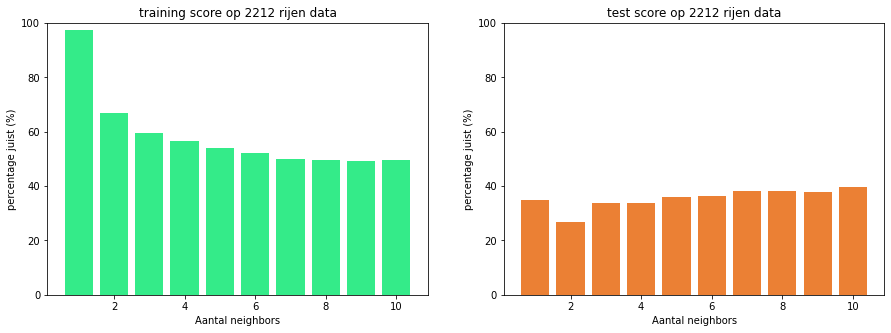

In [694]:
trainingScoreKNN = []
testScoreKNN = []
neighbors = 10

for k in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    
    trainingScoreKNN.append(round(knn.score(X_train, y_train) * 100, 2))
    testScoreKNN.append(round(knn.score(X_test, y_test) * 100, 2))
    
    print("Iteratie: " + str(k))
    print("Accuracy op de training set: {:.3f}".format(knn.score(X_train, y_train)))
    print("Accuracy op de test set: {:.3f}".format(knn.score(X_test, y_test)))
    print("*-------------------------------*")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScoreKNN, align='center', color = "#34eb89")
ax1.set_ylim(0, 100)
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.bar(objects, testScoreKNN, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')
plt.show();

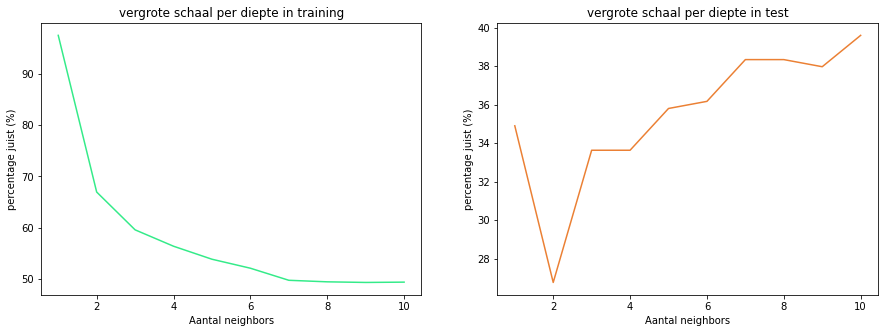

In [695]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(objects, trainingScoreKNN, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.plot(objects, testScoreKNN, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors');

### 3.1.1 - Finaal KNN-model met vaste waarde

We zien hieronder een duidelijke overfitting optreden (een beter prestatie van het model op de trainingsset als op de testset). De k waarde is zo relatief goed mogelijk gekozen maar omdat het een relatief kleine dataset is wordt het moeilijker om een goede voorspelling te doen en is de testscore vrij laag. Hoe hoger het aantal neightbors (k) hoe slechter de trainingsset zal scoren maar de testset doet het wel steeds een klein beetjebeter. Bij 1 neightbor is de trainingsscore zeer hoog, door overfitting blijft de testscore ook zeer laag.

In [696]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
trainingScore = round(knn.score(X_train, y_train), 2)
testScore = round(knn.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScore))
print("Test set score: " + str(testScore))

Training set score: 0.5
Test set score: 0.38


## 3.2 - Decision tree classifier model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage voor elke diepte op de hele trainingsset. De twee rechtse grafieken tonen het percentage van de testdata voor elke diepte. Hieruit blijkt dat op de trainingsdata het slaagpercentage toeneemt bij een hogere diepte, dit blijft doorgaan tot een diepte van 27, hierna vlakt de score af tot 97% maar is er een zeer grote overfitting aanwezig. Het is uiteraard ook niet goed om een te hoge diepte in te stellen omdat er dan te veel opsplitsingen gebeuren en zo het model te specifiek wordt getrained op de aangeleverde dataset. Het decision tree algoritme is ook heel wat sneller dan het KNN classifier model.

De 2 onderste grafieken geven een ingezoomde lijn grafiek weer om het verloop tussen beter zichtbaar te maken.

Iteratie: 1
Accuracy op de training set: 0.436
Accuracy op de test set: 0.436
*-------------------------------*
Iteratie: 2
Accuracy op de training set: 0.436
Accuracy op de test set: 0.436
*-------------------------------*
Iteratie: 3
Accuracy op de training set: 0.446
Accuracy op de test set: 0.432
*-------------------------------*
Iteratie: 4
Accuracy op de training set: 0.458
Accuracy op de test set: 0.432
*-------------------------------*
Iteratie: 5
Accuracy op de training set: 0.471
Accuracy op de test set: 0.436
*-------------------------------*
Iteratie: 6
Accuracy op de training set: 0.486
Accuracy op de test set: 0.429
*-------------------------------*
Iteratie: 7
Accuracy op de training set: 0.513
Accuracy op de test set: 0.400
*-------------------------------*
Iteratie: 8
Accuracy op de training set: 0.550
Accuracy op de test set: 0.414
*-------------------------------*
Iteratie: 9
Accuracy op de training set: 0.579
Accuracy op de test set: 0.403
*-------------------------

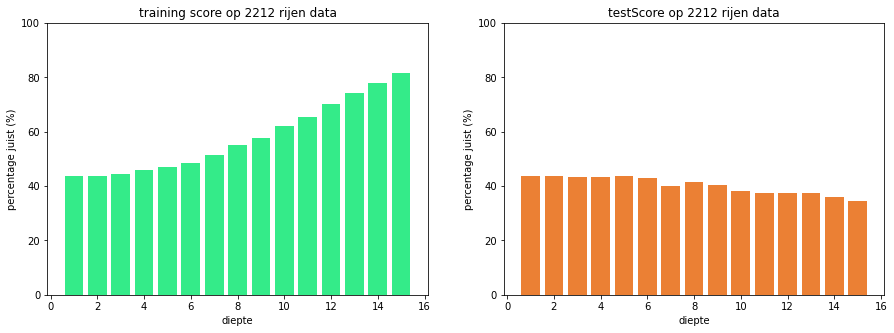

In [697]:
trainingScoreDec = []
testScoreDec = []
depth = 15

for n in range(1, depth + 1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScoreDec.append(round(treeModel.score(X_train, y_train) * 100, 2))
    testScoreDec.append(round(treeModel.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy op de training set: {:.3f}".format(treeModel.score(X_train, y_train)))
    print("Accuracy op de test set: {:.3f}".format(treeModel.score(X_test, y_test)))
    print("*-------------------------------*")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, depth + 1)

ax1.bar(objects, trainingScoreDec, align='center', color = "#34eb89")
ax1.set_ylim(0, 100)
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.bar(objects, testScoreDec, align='center', color = "#eb8034")
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte');

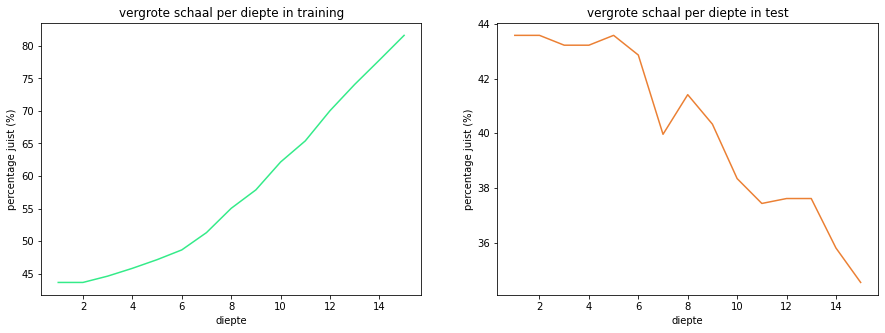

In [698]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(objects, trainingScoreDec, color = "#34eb89")
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScoreDec, color = "#eb8034")
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte');

### 3.2.1 - Finaal Decision tree model

We zien hieronder terug een duidelijke overfitting optreden. De decision tree is bij een hoge diepte acurater in de trainingsset maar het bljft slecht scoren op de testset. In de grafieken hierboven zagen we ook dat de test scores zeer gelijk bleven en niet veel verbeterden. Met een diepte van 12 krijgen we een trainingsscore van 82% en op de testset een lage 35%. Terug denk ik dat door de gekozen features deze scores omlaag worden getrokken en dat dit mogelijks kan worden verbeterd met een grotere dataset en andere opschoonmethodes.

In [699]:
treeModelReg = DecisionTreeClassifier(max_depth=15, random_state=42).fit(X_train, y_train)

print("Cross validation score: " + str(cross_val_score(treeModelReg, X_train, y_train, cv=5)))
print("Training set score: " + str(round(treeModelReg.score(X_train, y_train), 2)))
print("Test set score: " + str(round(treeModelReg.score(X_test, y_test), 2)))

Cross validation score: [0.43373494 0.40060241 0.37951807 0.3373494  0.29607251]
Training set score: 0.82
Test set score: 0.35


Plotten van de decision tree en opslaan als png

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15), dpi=680);
tree.plot_tree(treeModelReg, feature_names = feature_names, filled = True);
fig.savefig('DecisionTree.png');

## 3.3 - Logistic regression

Logistic regression is een lineair model voor classificatie. Het gebruikte algoritme heet *Solver*. De solver is ingesteld op *liblinear* aangezien dit een multiclass dataset kan verwerken en dit gebaseerd is op kansverhoudingen. De verhouding tussen de fracties bij twee mogelijke uitkomsten wordt hierin bepaald en zo geclassificeerd. Dit principe wordt uitgevoerd en vervolgens herhaald indien het in de rest thuishoort (een soort van binaire classificatie).

De score is in beide gevallen vrij laag op de tranings- en testset omdat dit een binair clasificatie methode is.

In [700]:
logRegr = LogisticRegression(solver='liblinear', max_iter=500, multi_class = 'auto').fit(X_train, y_train)
#print(logRegr.predict(X_test[384].reshape(1, -1)))
#print(logRegr.predict(X_test[0:10]))

print("Training set score: {:.3f}".format(logRegr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logRegr.score(X_test, y_test)))

Training set score: 0.435
Test set score: 0.427


## 3.4 - Random forest tree

Het Random forest tree cassifier alogritme is een verzameling van decision trees. Elke tree doet een voorspelling maar loopt ook heel wat kans om de voorspellingen te gaan overfitten. Bij random forest worden meerdere trees parallel geraadplaagd en geven ze elk hun parameters mee. Uit deze resultaten zal dan een eindresultaat komen. In dit model wordt er gebruik gemaakt van 100 parallelle trees en een random state om in de dataset willekeurigheid te hebben.

Dit model scoort matig op de testset maar heeft duidelijk een hele hoge overfitting. Met een enorme score van 97% op de trainingsset scoort het model zeer hoog maar in tegenstelling tot de testset is er nog veel ruimte over op verbetering.

In [701]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, np.ravel(y_train, order='C'))
y_predForest = forest.predict(X_test)

print("Training set score: {:.3f}".format(forest.score(X_train, y_train), 2))
print("Test set score: {:.3f}".format(forest.score(X_test, y_test), 2))

Training set score: 0.976
Test set score: 0.414


# 4 - Bijstellen van features


## 4.1 - KNN error evaluatie

De onderstaande grafiek toont het aantal fouten dat optreden bij het aantal K (neighbors) af tot maximaal 30 neighbors. In de grafiek kunnen we zien dat het aantal errors sterk afneemt naar mate er meer neighbors bijkomen.

Cross validation error voor 1 neighbors: 1.721
Cross validation error voor 2 neighbors: 1.563
Cross validation error voor 3 neighbors: 1.469
Cross validation error voor 4 neighbors: 1.409
Cross validation error voor 5 neighbors: 1.377
Cross validation error voor 6 neighbors: 1.357
Cross validation error voor 7 neighbors: 1.342
Cross validation error voor 8 neighbors: 1.316
Cross validation error voor 9 neighbors: 1.315
Cross validation error voor 10 neighbors: 1.31
Cross validation error voor 11 neighbors: 1.31
Cross validation error voor 12 neighbors: 1.31
Cross validation error voor 13 neighbors: 1.311
Cross validation error voor 14 neighbors: 1.303
Cross validation error voor 15 neighbors: 1.298
Cross validation error voor 16 neighbors: 1.297
Cross validation error voor 17 neighbors: 1.304
Cross validation error voor 18 neighbors: 1.301
Cross validation error voor 19 neighbors: 1.3
Cross validation error voor 20 neighbors: 1.3
Cross validation error voor 21 neighbors: 1.303
Cross va

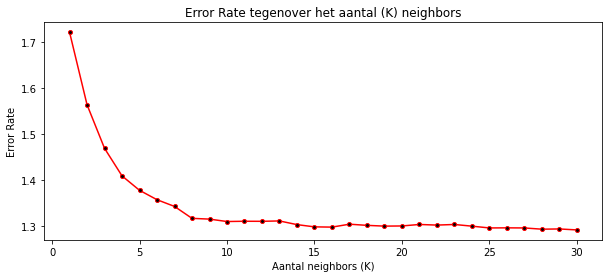

In [702]:
err_knn_val = [] 
neighbors = 30

for k in range(1, neighbors +1):
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error = math.sqrt(mean_squared_error(y_test, pred))
    err_knn_val.append(error)                                                
    print("Cross validation error voor " + str(k) + " neighbors: " + str(round(error, 3)))

plt.figure(figsize=(10, 4))
plt.plot(range(1, neighbors+1), err_knn_val, color="red", marker="o", markerfacecolor="black", markersize=4)
plt.title("Error Rate tegenover het aantal (K) neighbors")
plt.xlabel("Aantal neighbors (K)")
plt.ylabel("Error Rate")
plt.show();

## 4.2 - Cross validation

Cross validatie is een techniek om te beschermen tegen overfitting in een model. Bij cross validatie wordt er een vast aantal folds (of partities) van de gegevens genomen samen met een willekeurigheid van de dataset, daarna wordt de analyse uitgevoerd op elke fold en een gemiddelde van de totale foutschatting berekend.

Deze techniek wordt hieronder uitgevoerd met KNN (k-nearest neighbors), Linaire regressie en Decision tree.

### 4.2.1 - Cross validation met KNN

In [703]:
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

KNN = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

df_knn = pd.DataFrame(cross_validate(KNN, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(KNN, X, y, cv = 5)

print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_knn

Cross-validation scores: [0.25507901 0.27088036 0.32352941 0.31447964 0.31447964]
Average cross-validation score: 0.30


,fit_time,score_time,test_score,train_score
0,0.003008,0.012781,0.355856,0.552764
1,0.001879,0.009466,0.346847,0.539196
2,0.001952,0.011250,0.348416,0.550979
3,0.001859,0.009677,0.325792,0.545455
4,0.001831,0.011342,0.298643,0.554495
5,0.001802,0.009355,0.343891,0.550979
6,0.001817,0.009529,0.316742,0.540934
7,0.002369,0.012974,0.339367,0.552988
8,0.002633,0.012463,0.352941,0.544450
9,0.002464,0.012858,0.371041,0.552486


### 4.2.2 - Cross validation met linear regression

In [704]:
def min_max_scaler(df):
    X = df.drop(['delta periode vertrek', 'Aantal dagen tot vertrek', 'Klantnummer', 'Openstaand dossier', 'Geboortedatum', 'Dossier nr.', 'Betalingen dossier',  'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
    y = df['delta periode vertrek']
    feature_names = X.columns
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X), y, feature_names

X_lin, y_lin, feature_names = min_max_scaler(features)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, random_state=0)

linreg = LinearRegression().fit(X_train_lin, y_train)
y_pred = linreg.predict(X_test_lin)

print("lr.coef_:", linreg.coef_)
print("lr.intercept_:", linreg.intercept_)

score_mse = mean_squared_error(y_test_lin, y_pred)
score_mae = mean_absolute_error(y_test_lin, y_pred)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(linreg, X_lin, y_lin, cv= folds)

print("")
print("Mean squared error score: {}".format(score_mse))
print("Absolute mean squared error score: {}".format(score_mae))
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

lr.coef_: [-0.33481263  0.35863137  1.66551917 -1.1697301  -0.0761308  -0.21608999
  0.59868841 -2.34545482 -0.06640226]
lr.intercept_: 3.9528543785005152

Mean squared error score: 20869.585893604497
Absolute mean squared error score: 106.38818778801416
Cross-validation scores: [0.01812218 0.02199458 0.03441865 0.06095646 0.04317601]
Average cross-validation score: 0.04


### 4.2.3 - Cross validation met decision tree

In [705]:
decTree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

df_dec = pd.DataFrame(cross_validate(decTree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(decTree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_dec

Average cross-validation score: 0.41


,fit_time,score_time,test_score,train_score
0,0.003540,0.000610,0.418919,0.471859
1,0.003500,0.000468,0.418919,0.464322
2,0.003407,0.000406,0.425339,0.463586
3,0.003563,0.000420,0.452489,0.460573
4,0.003497,0.000487,0.393665,0.465595
5,0.003606,0.000482,0.416290,0.465595
6,0.003463,0.000417,0.407240,0.468106
7,0.003328,0.000457,0.425339,0.460070
8,0.003303,0.000393,0.452489,0.459568
9,0.003282,0.000421,0.434389,0.465595


## 4.3 - Grid Search

Grid search is een methode om de best mogelijke combinatie van parameters te vinden waarbij het model de hoogste nauwkeurigheid behaalt. In dit deel wordt grid search toegepast op KNN, Decision tree en random forest en wordt het beste model daarna gevalideerd.

Hieronder splitten we de data terug op maar met deze keer een derde deel, namelijk de validatieset. Met deze validatiesets gaan we berekenen welk model het beste presteert.

In [706]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_validation, y_train_validation, random_state=42)

print("Grootte van trainingsset: {}, Grootte van validationset: {}, Grootte van testset:"" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Grootte van trainingsset: 1244, Grootte van validationset: 415, Grootte van testset: 553



### 4.3.1 - Grid Search in KNN

In [707]:
beste_model = 0
beste_score = 0
beste_parameters = 0
top_score = 0
neighbors = 10

for k in range(1, neighbors + 1):
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    score = KNN.score(X_valid, y_valid)
    
    if score > beste_score:
        beste_parameters = {'n_neighbors': k}
        beste_score = score
        if score > top_score:
            beste_model = knn
            top_score = score

knn = KNeighborsClassifier(**beste_parameters).fit(X_train_validation, y_train_validation)
training_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Trainingsset score met de beste gekozen parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'n_neighbors': 10}

Trainingsset score met de beste gekozen parameters: 0.48
Beste score op de validatie set: 0.38
Test set score met de best gekozen parameters: 0.36


### 4.3.2 - Grid Search in Decision tree

In [708]:
beste_score = 0
max_depth = 15

for depth in range(1, max_depth + 1):
    for random_st in [0, 5, 10, 20, 40]:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=random_st)
        tree.fit(X_train, y_train)
        score = tree.score(X_valid, y_valid)
        
        if score > beste_score:
            beste_parameters = {'max_depth': depth, 'random_state': random_st}
            beste_score = score
            if score > top_score:
                beste_model = tree
                top_score = score

tree = DecisionTreeClassifier(**beste_parameters)
tree.fit(X_train_validation, y_train_validation)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Training set score with best parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'max_depth': 3, 'random_state': 0}

Training set score with best parameters: 0.43
Beste score op de validatie set: 0.47
Test set score met de best gekozen parameters: 0.43


### 4.3.3 - Grid Search met Random forest tree

In [709]:
beste_score = 0
max_estimators = 50

for n in range(1, max_estimators):
    for random_st in [0, 5, 10, 20, 40]:
        rfc = RandomForestClassifier(n_estimators=n, random_state=random_st).fit(X_train, y_train)
        score = rfc.score(X_valid, y_valid)

        if score > beste_score:
            beste_parameters = {'n_estimators': n, 'random_state':random_st}
            beste_score = score
            if score > top_score:
                beste_model = rfc
                topScore = score

rfc = RandomForestClassifier(**beste_parameters).fit(X_train_validation, y_train_validation)
training_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("Beste parameters:", beste_parameters)
print("")
print("Training set score with best parameters: {:.2f}".format(training_score))
print("Beste score op de validatie set: {:.2f}".format(beste_score))
print("Test set score met de best gekozen parameters: {:.2f}".format(test_score))

Beste parameters: {'n_estimators': 34, 'random_state': 0}

Training set score with best parameters: 0.98
Beste score op de validatie set: 0.45
Test set score met de best gekozen parameters: 0.41


## 4.4 - Grid Search in combinatie met Cross-validation

Na het bepalen van het beste model wordt er cross validation toegepast op Decision tree en Random forest om overfitting op de trainingsset te minimaliseren. Bij elk model worden de beste parameters en de cross validatie score weergegeven.

### 4.4.1 - Grid Search en Cross-validation met Decision tree

In [710]:
param_grid = {'max_depth': [1, 2, 3, 4, 5], 'random_state': [0, 5, 10, 20, 40]}
print("Parameter grid:{}".format(param_grid))

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Beste parameters: {}".format(grid_search.best_params_))
print("Beste cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator: {}".format(grid_search.best_estimator_))

Parameter grid:{'max_depth': [1, 2, 3, 4, 5], 'random_state': [0, 5, 10, 20, 40]}
Test set score: 0.44
Beste parameters: {'max_depth': 2, 'random_state': 0}
Beste cross-validation score: 0.41
Best estimator: DecisionTreeClassifier(max_depth=2, random_state=0)


### 4.4.2 - Grid Search en Cross-validation met Random forest

In [711]:
param_grid = {'max_depth': [11, 12, 13], 'random_state': [35, 40, 50], 'n_estimators': [75, 100, 125]}

gridSearchTrees = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,return_train_score=True)

gridSearchTrees.fit(X_train, y_train)
pred = gridSearchTrees.predict(X_test)
trainingScoreTrees = round(gridSearchTrees.score(X_train, y_train), 2)
testScoreTrees = round(gridSearchTrees.score(X_test, y_test), 2)

print("Training set score: " + str(trainingScoreTrees))
print("Test set score: " + str(testScoreTrees))
print("Beste parameters: {}".format(gridSearchTrees.best_params_))
print("Beste cross-validation score: {:.2f}".format(gridSearchTrees.best_score_))
print("Best estimator: {}".format(gridSearchTrees.best_estimator_))

Training set score: 0.84
Test set score: 0.43
Beste parameters: {'max_depth': 13, 'n_estimators': 125, 'random_state': 35}
Beste cross-validation score: 0.43
Best estimator: RandomForestClassifier(max_depth=13, n_estimators=125, random_state=35)


## 4.5 - Feature importance

De onderstaande grafieken tonen aan hoe belangrijk de features zijn bij het voorspellen van elk model. 
We kunnen zien dat de *Totaalprijs* en *leeftijd*, samen met *aantal dagen op reis* sterk bepalen welke richting het model uitgaat. Beide modellen (decision tree en random forest) lijken goed op elkaar, namelijk omdat random forest gebaseerd is op het decision tree model.

### 4.5.1 - Decision tree (3.2.1)

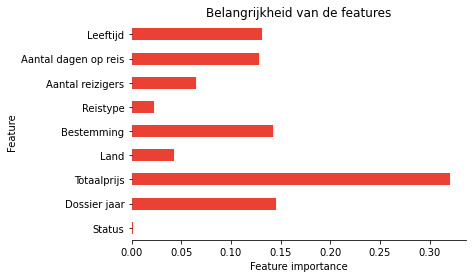

In [712]:
bar = (pd.Series(treeModelReg.feature_importances_, index=feature_names).plot(kind='barh', color= "#eb4034"));

plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Belangrijkheid van de features")
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['left'].set_visible(False)
plt.show();

### 4.5.2 - Random Forest (3.4)

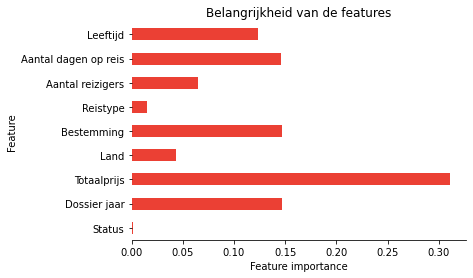

In [713]:
bar = (pd.Series(forest.feature_importances_, index=feature_names).plot(kind='barh', color= "#eb4034"));
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Belangrijkheid van de features")
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['left'].set_visible(False)
plt.show();

# 5 - Beste gekozen model

In [714]:
training_score = beste_model.score(X_train, y_train)
test_score = beste_model.score(X_test, y_test)
pred_model = beste_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, pred_model)

print("beste gekozen model met properties:", beste_model)
print("")
print("Training set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(beste_score))
print("Test set score with best parameters: {:.2f}".format(test_score))
print("Confusion matrix:\n{}".format(conf_matrix))

beste gekozen model met properties: DecisionTreeClassifier(max_depth=3, random_state=0)

Training set score with best parameters : 0.44
Best score on validation set: 0.45
Test set score with best parameters: 0.43
Confusion matrix:
[[  0   7   1   1  26]
 [  0   2   2   0  55]
 [  0   3   0   3 105]
 [  0   4   2   1  99]
 [  1   4   3   1 233]]


## 5.1 - Conclusie

Bij de scores van de verschillend modellen onderling kan ik vaststellen dat alle modellen maar zwak tot matig scoorden. Er is ook steeds een grote vorm van overfitting aanwezig wat denk ik te maken heeft met de kwaliteit van de features in combinatie met een te kleine dataset. Het voorspellen van de categorieën verliep bij de 4 algoritmes ongeveer gelijk, zowat elk algoritme behalve Logistic regression.

KNN, Desicion tree en Random forest tree hadden alle 3 overfitting op de scores. Logistic regiression had dan weer een lage score maar had op de train en test score een gelijke waarde.

Het uiteindelijke multiclass decision tree model heeft een train score van 44%, een test score van 43% en een validatie score van 45%. Deze waarden liggen zeer dicht bij elkaar wat een goede maat is tussen train en test data. Tussen de train- en testdata is er een kleine overfitting aanwezig. De scores zijn best aan de lage kant, dit zou eventueel kunnen verbeterd worden door het datapreparartion proces beter uit te voeren.

Tijdens het uitwerken van dit project heb ik heel wat diverse testen gedaan met verschillende features, deze combinatie heeft in het algemeen de beste prestaties geleverd.